In [1]:
%%capture nop
import os 
IS_KAGGLE = not not os.environ.get('KAGGLE_KERNEL_RUN_TYPE','')
if IS_KAGGLE:
    !git clone https://github.com/Janluke0/PoS-Tagging/
    os.chdir('PoS-Tagging')
    !pip install positional-encodings
else:
    os.chdir('..')

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pytorch_lightning as pl
import torch
GPU = 1 if torch.cuda.is_available() else 0

from dataset.tokenizer import get_tokenizer
from dataset.twtita import mk_dataloaders, TWITADS

import model.transformer as trans
TAGS = TWITADS._TAGS

In [3]:
def mk4tknzr(name):
    tknzr = get_tokenizer('resampled_train',name)
    ntags, dl_train = mk_dataloaders(tknzr,['resampled_train'], batch_size=512, align_labels=False)
    vocab = tknzr.vocab_size if hasattr(tknzr,'vocab_size')  else tknzr.get_vocab_size()
    _, dl_val, dl_test = mk_dataloaders(tknzr,['resampled_validation','test'], 
                                        shuffle=False,batch_size=512, align_labels=False,
                                        add_final_pad=True)#this allow to shift the target without drop the last (meaningful) element
    model =  trans.TokenizedSeq2Seq(d_input=vocab,
                 d_model=128,
                 d_output=len(TAGS),
                 nheads=1,
                 dropout=0.1,
                 n_encoder=1,
                 n_decoder=1,
                 src_pad_idx=0,
                 tgt_pad_idx=0)
    pl_model = trans.PLWrapper(model,
                                    #labels ignored for pure accuracy computation
                                    label_idx_to_ignore=[ TAGS['[EPAD]'],TAGS['[BOS]'], TAGS['[EOS]'], TAGS['[PAD]']])
    return pl_model, (dl_train,dl_val,dl_test) #, model


def plot_curves(model):
    acc, loss = model.val_metrics['accuracy'],model.val_metrics['loss']
    print(acc[-1],max(acc))
    print(loss[-1],min(loss))
    plt.figure(figsize=(16,8))
    plt.subplot(121)
    plt.plot(acc)
    plt.subplot(122)
    plt.plot(loss)
    
early_stopping = lambda: pl.callbacks.EarlyStopping(monitor='val_acc',min_delta=1e-6,mode='max',patience=400)
checkpoints = lambda: pl.callbacks.ModelCheckpoint(monitor='val_acc',mode='max')

In [4]:
%%capture nop
model, (dl_train,dl_val,dl_test) = mk4tknzr('BPE')
trainer = pl.Trainer(log_every_n_steps=2,gpus=GPU, max_epochs=2000, callbacks=[early_stopping(), checkpoints()])
trainer.fit(model, dl_train, dl_val)

0.6781874895095825 0.6867170333862305
1.9287846088409424 1.141005039215088


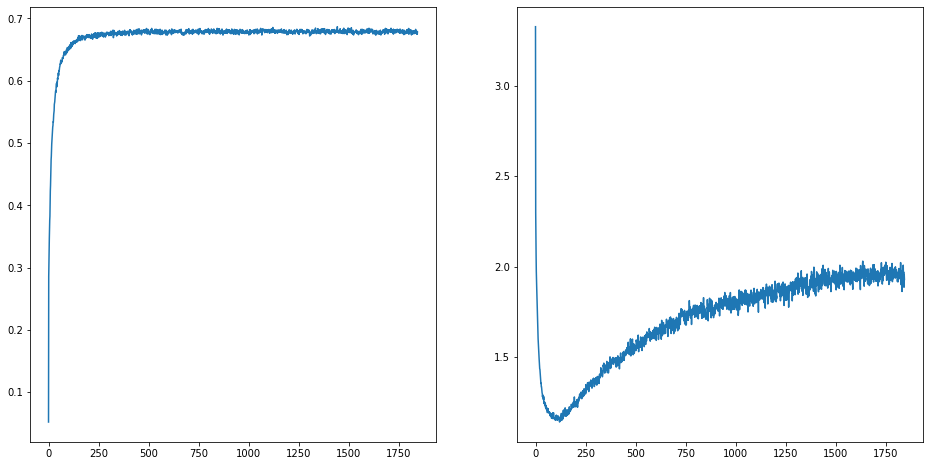

In [5]:
plot_curves(model)

In [6]:
%%capture nop
model, (dl_train,dl_val,dl_test) = mk4tknzr('WordPiece')
trainer = pl.Trainer(log_every_n_steps=2,gpus=GPU, max_epochs=2000, callbacks=[early_stopping(), checkpoints()])
trainer.fit(model, dl_train, dl_val)

0.6862779855728149 0.6966761350631714
1.5951260328292847 1.0285025835037231


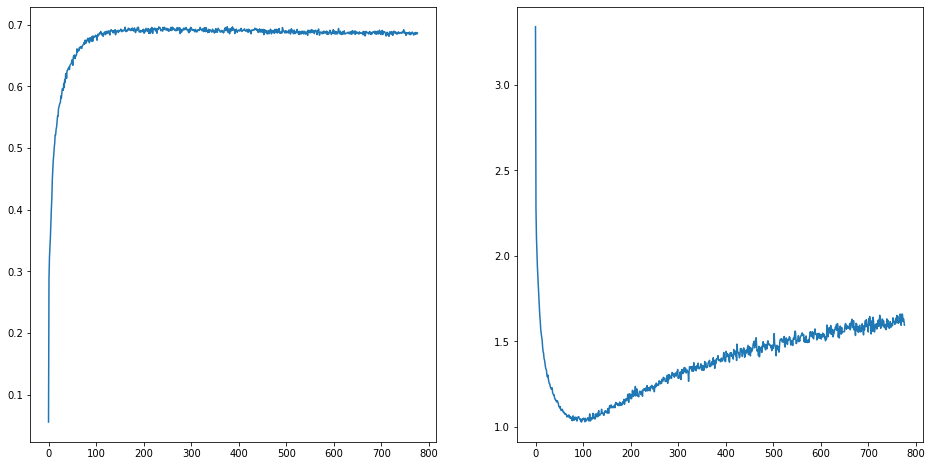

In [7]:
plot_curves(model)

In [8]:
%%capture nop
model, (dl_train,dl_val,dl_test) = mk4tknzr('BERT_pretrained')
trainer = pl.Trainer(log_every_n_steps=2,gpus=GPU, max_epochs=2000, callbacks=[early_stopping(), checkpoints()])
trainer.fit(model, dl_train, dl_val)

0.590117335319519 0.6122466921806335
2.5612666606903076 1.2376312017440796


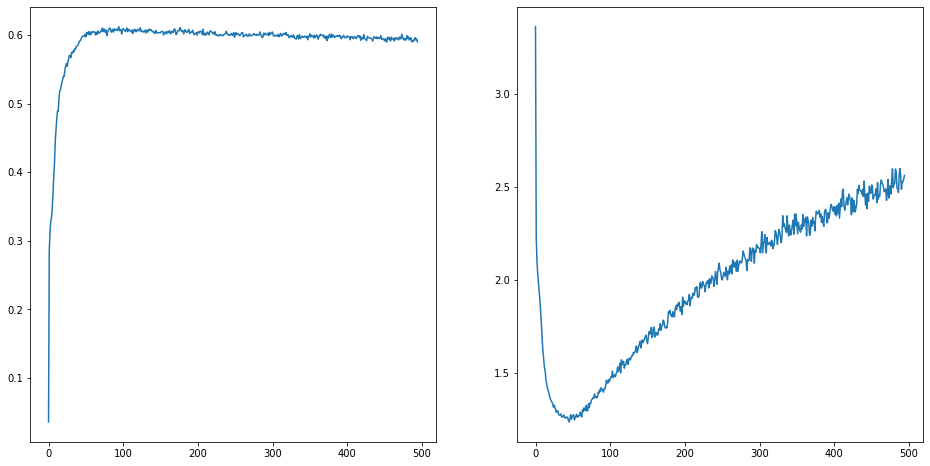

In [9]:
plot_curves(model)

In [10]:
%%capture nop
model, (dl_train,dl_val,dl_test) = mk4tknzr('DBERT_pretrained')
trainer = pl.Trainer(log_every_n_steps=2,gpus=GPU, max_epochs=2000, callbacks=[early_stopping(), checkpoints()])
trainer.fit(model, dl_train, dl_val)

0.582940936088562 0.6004442572593689
2.4408442974090576 1.2832969427108765


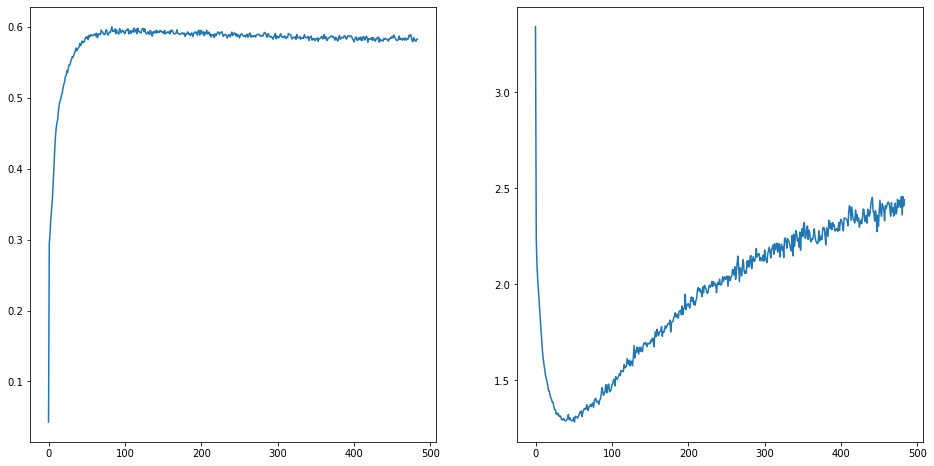

In [11]:
plot_curves(model)

In [12]:
%%capture nop
model, (dl_train,dl_val,dl_test) = mk4tknzr('ELECTRA_pretrained')
trainer = pl.Trainer(log_every_n_steps=2,gpus=GPU, max_epochs=2000, callbacks=[early_stopping(), checkpoints()])
trainer.fit(model, dl_train, dl_val)

0.5634828805923462 0.5818747282028198
2.6405060291290283 1.3061203956604004


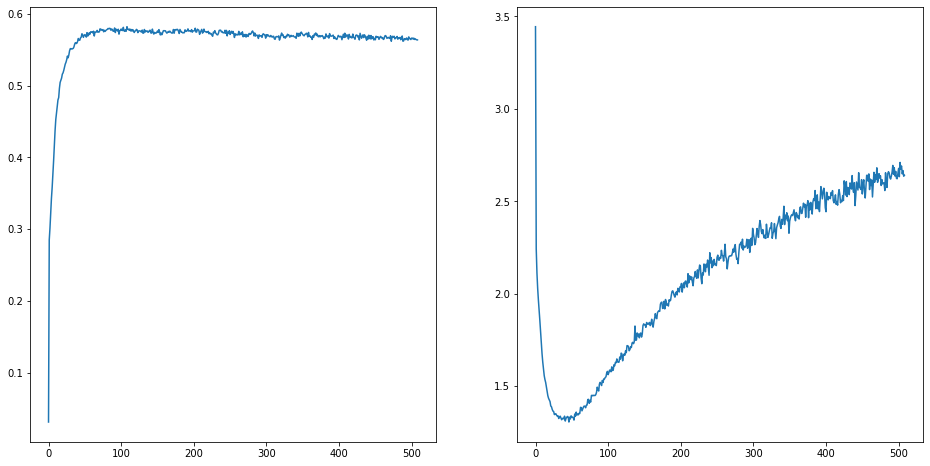

In [13]:
plot_curves(model)

In [14]:
%%capture nop
model, (dl_train,dl_val,dl_test) = mk4tknzr('ROBERTA_pretrained')
trainer = pl.Trainer(log_every_n_steps=2,gpus=GPU, max_epochs=2000, callbacks=[early_stopping(), checkpoints()])
trainer.fit(model, dl_train, dl_val)

0.5750333070755005 0.5901377201080322
2.5795230865478516 1.281643033027649


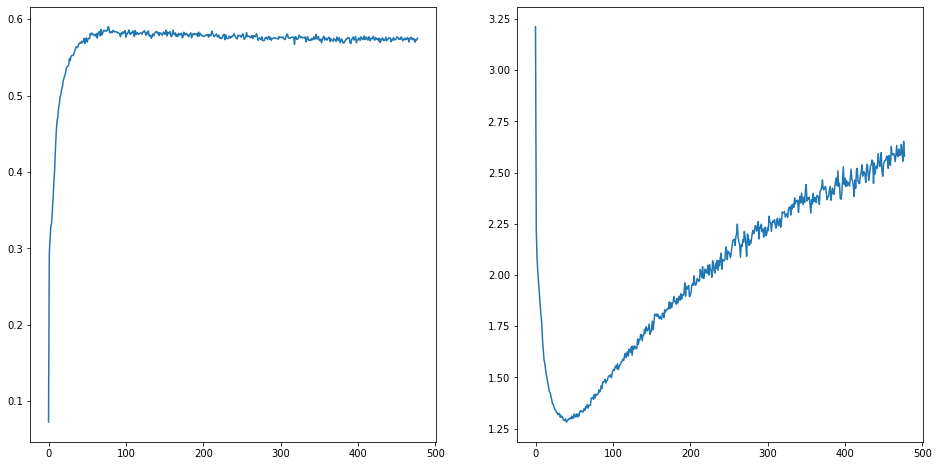

In [15]:
plot_curves(model)